In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('SpamDetectionDataset/spam.csv', header=None, sep=',', names=["target", "text", "x1", "x2", "x3"])

**1. Data cleaning**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
 2   x1      50 non-null     object
 3   x2      12 non-null     object
 4   x3      6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.head()

,target,text,x1,x2,x3
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# Drop 3 columns
df = df.drop(columns=['x1', 'x2', 'x3'])

In [6]:
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [7]:
df['target']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: target, Length: 5572, dtype: int32

In [8]:
#Missing value
df.isnull().sum()

target    0
text      0
dtype: int64

In [9]:
# check for duplicate value
df.duplicated().sum()

403

In [10]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [11]:
df.shape

(5169, 2)

**2. EDA - Exploratory Data Analysis**

In [12]:
df['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

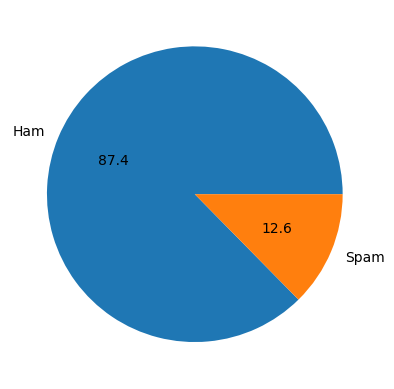

In [13]:
# Piechart -  the visualise better understanding of data int target column
plt.pie(df['target'].value_counts(), labels=['Ham', 'Spam'], autopct='%0.1f')
plt.show()

**Hence, Data is imbalance**

In [14]:
# To find the how many words, sentences are there in the SMSs
# %pip install nltk

import nltk

In [15]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

*To count the number of columns*

In [16]:
df['text'].apply(len)
df['num_chars'] = df['text'].apply(len)

*To fetch the number of words in the sms* 

In [17]:
df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

*To get the number of sentences in a SMS*

In [18]:
df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))
df['num_sent'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [19]:
df.head()

,target,text,num_chars,num_words,num_sent
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [20]:
print("Description for Ham(0) messages")

df[df['target'] == 0][['num_chars', 'num_words', 'num_sent']].describe()

Description for Ham(0) messages


,num_chars,num_words,num_sent
count,4516.000000,4516.000000,4516.000000
mean,70.457263,17.123782,1.820195
std,56.357463,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [21]:
print("Description for Spam(1) messages")

df[df['target'] == 1][['num_chars', 'num_words', 'num_sent']].describe()

Description for Spam(1) messages


,num_chars,num_words,num_sent
count,653.000000,653.000000,653.000000
mean,137.479326,27.675345,2.978560
std,30.014336,7.011513,1.493185
min,13.000000,2.000000,1.000000
25%,131.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


<Axes: xlabel='num_chars', ylabel='Count'>

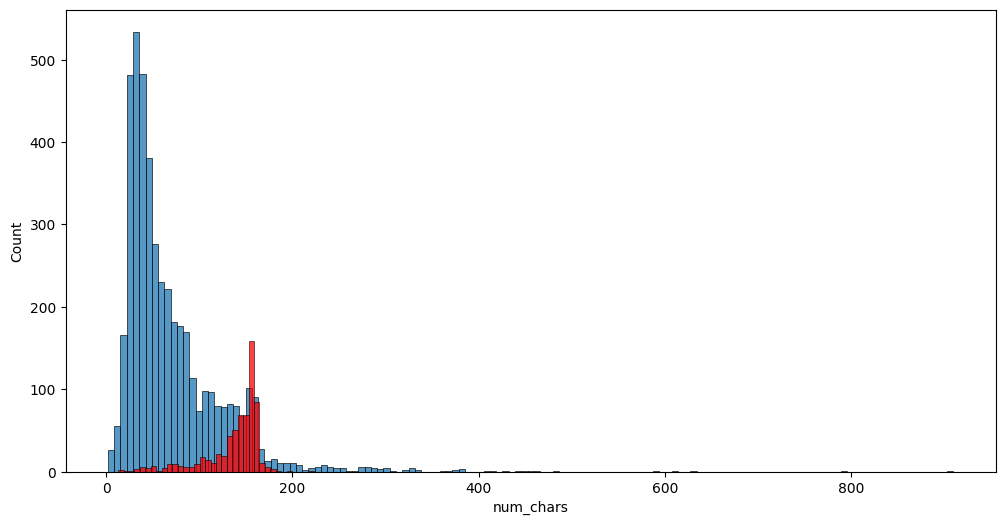

In [22]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target'] == 0]['num_chars'])
sns.histplot(df[df['target'] == 1]['num_chars'], color='red')

<Axes: xlabel='num_words', ylabel='Count'>

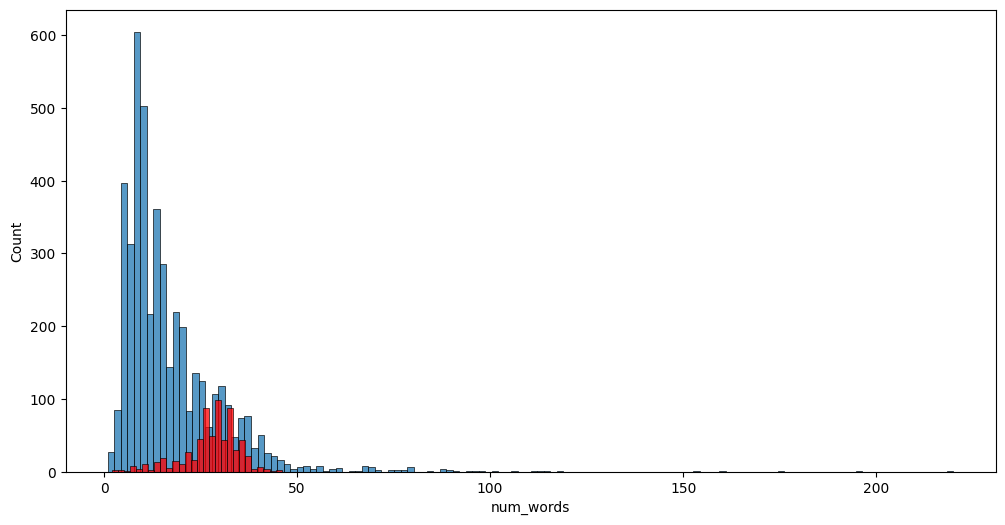

In [23]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'], color='red')

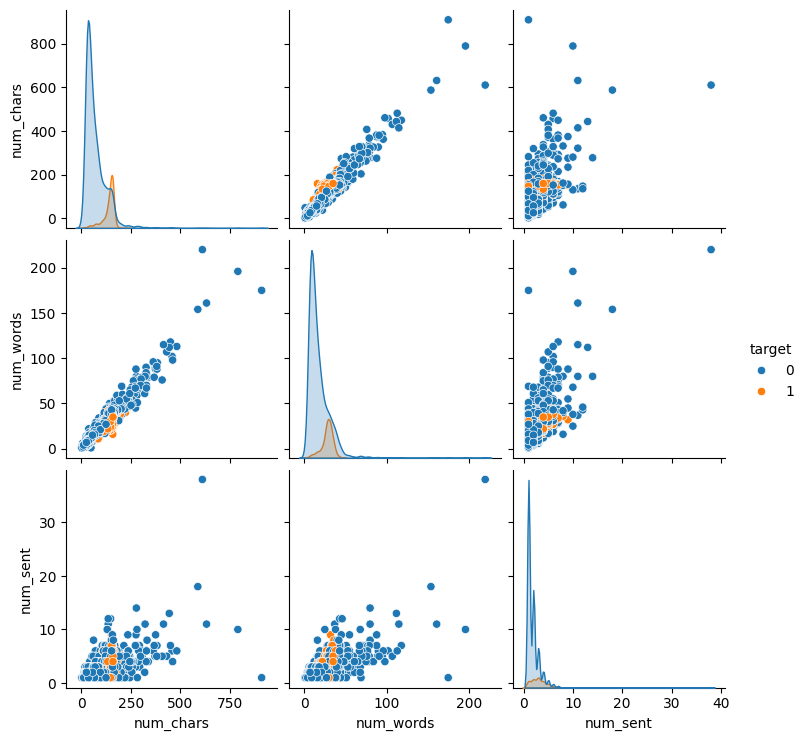

In [24]:
sns.pairplot(df, hue='target')

*Above data have some outlier that can possibly effect the analysis*

In [25]:
df['text'].dtype
df['num_chars'].dtype

dtype('int64')

<Axes: >

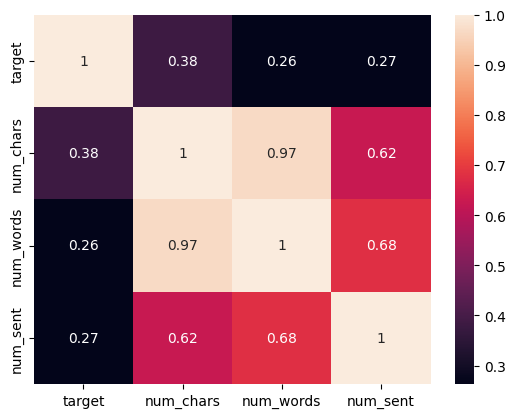

In [26]:
# Checking the co-relation
my_df = df.select_dtypes(exclude=['O'])
sns.heatmap(my_df.corr(), annot=True)

**3. Data Preprocessing**
- Lower case
- Tokenization
- Removing special characters[-, _, @, #, etc]
- Removing stop-words[is, an, the , of , etc] and punctuation[and, or, between, etc]
- Stemming - Covert the similar type of word to base word eg. - [dance, dancing, danced] -> "dance"

In [27]:
from nltk.corpus import stopwords
# nltk.download('stopwords')
import string
from nltk.stem import PorterStemmer

def transform_text(text):
    # Lower case
    text = text.lower()
    
    # Tokenization
    text = nltk.word_tokenize(text)
    
    # Removing special characters[-, _, @, #, etc]
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
            
    # Removing stop-words[is, an, the , of , etc] and punctuation[and, or, between, etc]
    text = y[:]
    y.clear()
    for i in text:
        if (i not in stopwords.words('english')) and (i not in string.punctuation):
            y.append(i)
            
    # Stemming - Covert the similar type of word to base word eg. - [dance, dancing, danced] -> "dance"
    porterStem = PorterStemmer()
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(porterStem.stem(i))
    
    
    return " ".join(y)

In [28]:
# stopwords.words('english')
# string.punctuation

In [29]:
df['transformed_text'] = df['text'].apply(transform_text)

In [30]:
df['transformed_text']

0       go jurong point crazi avail bugi n great world...
1                                   ok lar joke wif u oni
2       free entri 2 wkli comp win fa cup final tkt 21...
3                     u dun say earli hor u c alreadi say
4                    nah think goe usf live around though
                              ...                        
5567    2nd time tri 2 contact u pound prize 2 claim e...
5568                                b go esplanad fr home
5569                                    piti mood suggest
5570    guy bitch act like interest buy someth els nex...
5571                                       rofl true name
Name: transformed_text, Length: 5169, dtype: object

In [31]:
df.head()

,target,text,num_chars,num_words,num_sent,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [32]:
# %pip install wordcloud

In [33]:
from wordcloud import WordCloud

In [34]:
wordCloud = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
spam_wordCloud = wordCloud.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

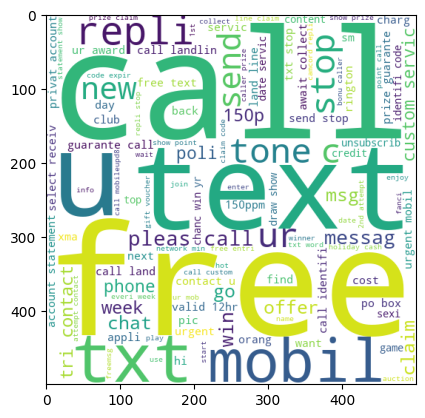

In [35]:
plt.imshow(spam_wordCloud)

In [36]:
wordCloud = WordCloud(width=500, height=500, min_font_size=10, background_color='white')
ham_wordCloud = wordCloud.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

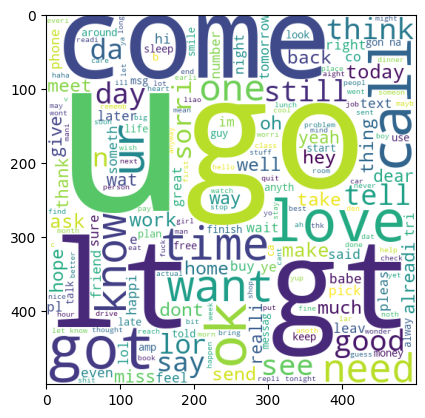

In [37]:
plt.imshow(ham_wordCloud)

*To get the top 30 words from the spam count*

In [38]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)
        
len(spam_corpus)

9941

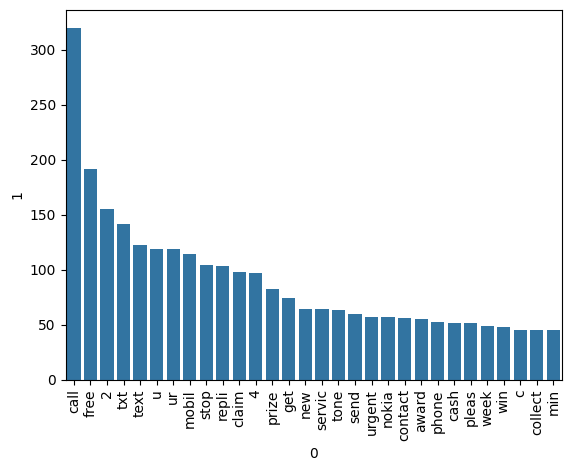

In [39]:
from collections import Counter
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [40]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)
        
len(ham_corpus)

35305

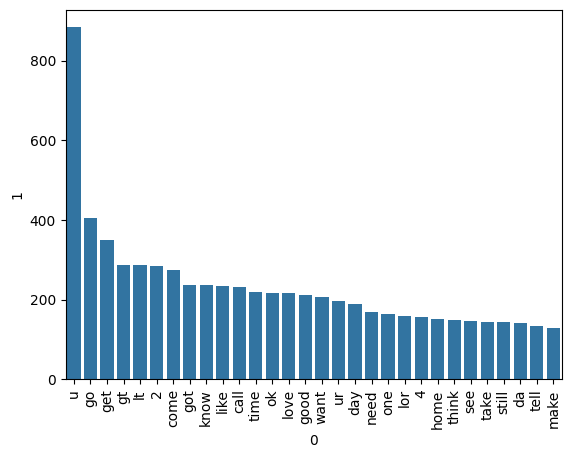

In [41]:
sns.barplot(x=pd.DataFrame(Counter(ham_corpus).most_common(30))[0], y=pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

**4. Model Building**

**A. Naive bayes algorythm**
- Step-1: Convert the text based data into numericals by Vectorizong the text.
    
    - Ways to do Text Vectorizatin / Feature extraction from text / Text representation.
    1. Bag of words - by making the column of frequent words and checking per word by the values in column
    2. TF-IDF
    3. Word to vect

*Why we take loge while calculating IDF?*
**Reason - by not taking the loge the IDF_value of any rare term could be 10000(N/n = 10000/1) and by taking Loge we get 4. This clear solves the existence of TF value should not be overcome the value of IDF(here: 10000), basically to smoothen out this kind of situation or we can say Normalizing the value of TF*IDF**

In [42]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [43]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [44]:
X.shape

(5169, 6677)

In [45]:
y = df['target'].values
y

array([0, 0, 1, ..., 0, 0, 0])

*Train-test-split*

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [48]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

In [49]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

svc = SVC(kernel='sigmoid', gamma=1.0)
lrc = LogisticRegression(solver='liblinear', penalty='l1')

In [50]:
classifiers = {
    'GNB': gnb,
    'MNB': mnb,
    'BNB': bnb,
    'SVC': svc,
    'LRC': lrc,
}

In [51]:
def train_classifier(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    prediction = classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    
    return accuracy, precision

In [52]:
accuracy_scores = []
precision_scores = []

for model_name, classifier in classifiers.items():
    accuracy, precision = train_classifier(classifier, X_train, X_test, y_train, y_test)
    
    print("For:", model_name)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("\n")
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)

For: GNB
Accuracy: 0.874274661508704
Precision: 0.518348623853211


For: MNB
Accuracy: 0.9593810444874274
Precision: 1.0


For: BNB
Accuracy: 0.971953578336557
Precision: 0.9823008849557522


For: SVC
Accuracy: 0.9729206963249516
Precision: 0.9741379310344828


For: LRC
Accuracy: 0.9516441005802708
Precision: 0.94




In [53]:
type(classifiers)

dict